In [35]:
import os
import re
from datetime import datetime

import pandas as pd

# Function to process each calendar file
def process_calendar_file(calendar_file_path):
    calendar_df = pd.read_csv(calendar_file_path)

    # Extract date part from file name
    date_part = re.search(r'(\d{4}_\d{2})', calendar_file_path).group()

    # Convert 'date' to datetime and 'price' to numerical
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)

    # Convert 'available' to numerical (t = 1, f = 0)
    calendar_df['available'] = calendar_df['available'].map({'t': 1, 'f': 0})

    # Group by week and listing_id
    calendar_df['week'] = calendar_df['date'].dt.isocalendar().week
    weekly_grouped = calendar_df.groupby(['listing_id', 'week']).agg(
        weekly_availability=('available', 'mean'),
        weekly_avg_price=('price', 'mean'),
        weekly_avg_min_nights=('minimum_nights', 'mean'),
        weekly_avg_max_nights=('maximum_nights', 'mean')
    ).reset_index()

    # Add 'AI' column indicating if observation is after 05/25/2023
    event_date = datetime(2023, 5, 25)
    weekly_grouped['AI'] = (weekly_grouped['week'] > event_date.isocalendar().week).astype(int)

    # Modify 'T' column based on weekly_availability
    weekly_grouped['T'] = (weekly_grouped['weekly_availability'] > 0).astype(int)

    # File path for the exported CSV
    exported_weekly_file_path = f'weekly_calendar_data_{date_part}.csv'

    # Exporting the weekly grouped dataframe to a CSV file
    weekly_grouped.to_csv(exported_weekly_file_path, index=False)

    return exported_weekly_file_path

# Directory containing the files
directory = './'  # Replace with your directory path

# Find all 'calendar' CSV files in the directory
calendar_files = [f for f in os.listdir(directory) if 'calendar' in f and f.endswith('.csv')]

# Process each calendar file
for file in calendar_files:
    full_path = os.path.join(directory, file)
    output_file = process_calendar_file(full_path)
    print(f"Processed {file}, output saved to {output_file}")


Processed 2022_09_calendar.csv, output saved to weekly_calendar_data_2022_09.csv
Processed 2022_12_calendar.csv, output saved to weekly_calendar_data_2022_12.csv
Processed 2023_03_calendar.csv, output saved to weekly_calendar_data_2023_03.csv
Processed 2023_06_calendar.csv, output saved to weekly_calendar_data_2023_06.csv
Processed 2023_09_calendar.csv, output saved to weekly_calendar_data_2023_09.csv


In [36]:
# Function to merge files with a specific pattern
def merge_files_with_pattern(directory, pattern):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter files that match the pattern
    matching_files = [file for file in files if file.startswith(pattern) and file.endswith('.csv')]

    # Read and concatenate the data from each file
    merged_df = pd.concat([pd.read_csv(os.path.join(directory, file)) for file in matching_files], ignore_index=True)

    # Optionally, export the merged DataFrame to a new CSV file
    output_file = os.path.join(directory, 'merged_weekly_calendar_data.csv')
    merged_df.to_csv(output_file, index=False)

    return output_file

# Directory containing the files
directory = './'  # Replace with your directory path

# Merge files
output_file = merge_files_with_pattern(directory, 'weekly_calendar_data')
print(f"Merged file created at: {output_file}")


Merged file created at: ./merged_weekly_calendar_data.csv


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079109 entries, 0 to 1079108
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   listing_id             1079109 non-null  int64  
 1   week                   1079109 non-null  int64  
 2   weekly_availability    1079109 non-null  float64
 3   weekly_avg_price       1079103 non-null  float64
 4   weekly_avg_min_nights  1079107 non-null  float64
 5   weekly_avg_max_nights  1079107 non-null  float64
 6   AI                     1079109 non-null  int64  
 7   T                      1079109 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 65.9 MB
None

Missing Values:
listing_id               0
week                     0
weekly_availability      0
weekly_avg_price         6
weekly_avg_min_nights    2
weekly_avg_max_nights    2
AI                       0
T                        0
dtype: int64

Summary Statistics for Num

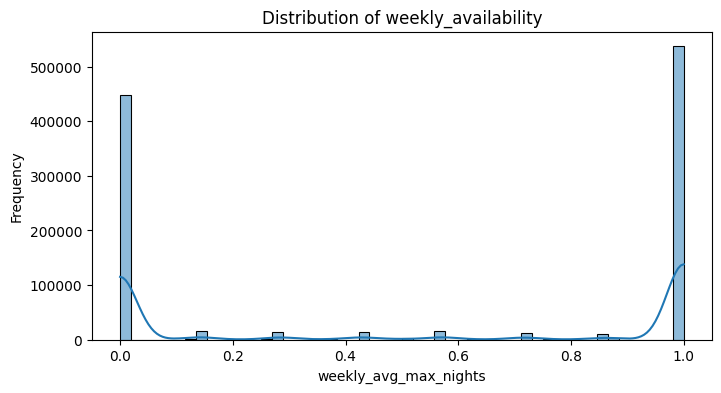

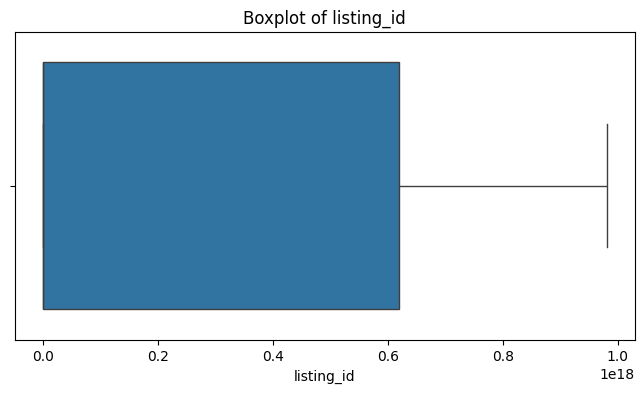

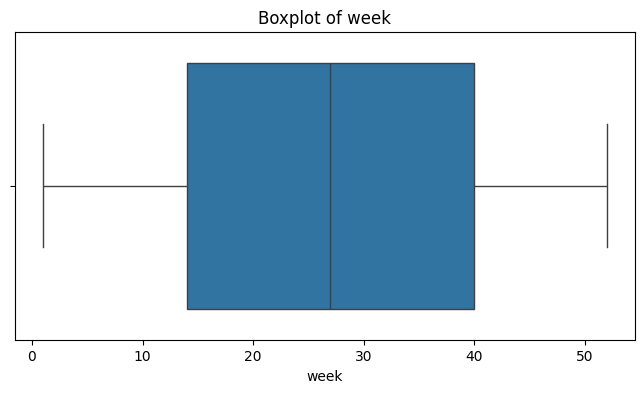

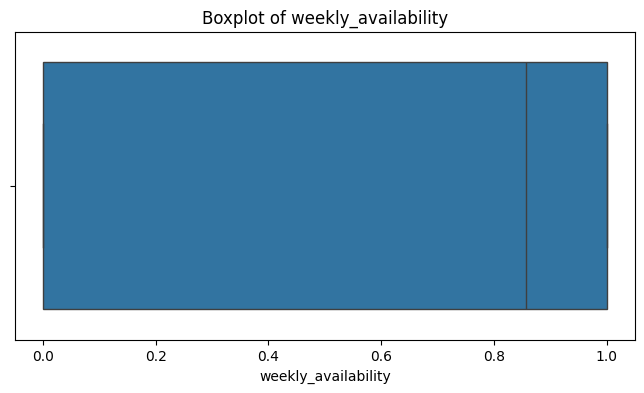

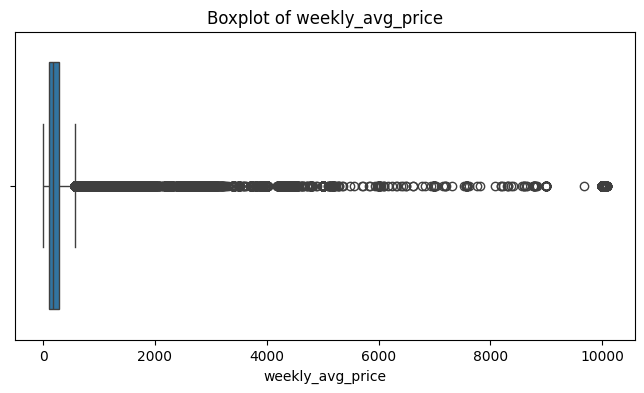

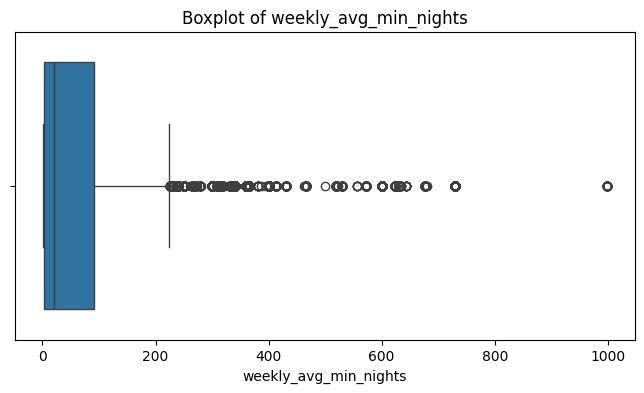

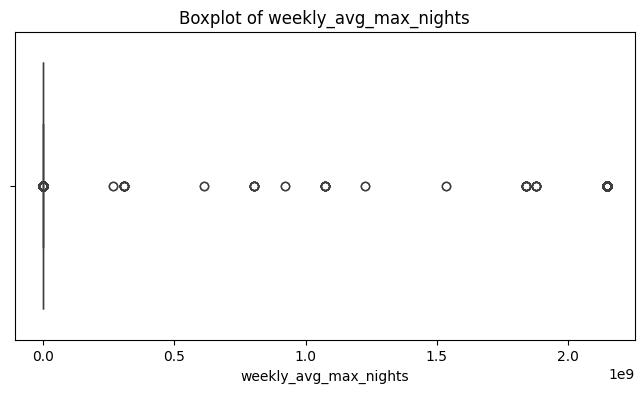

In [37]:
# Load the data
file_path = 'merged_weekly_calendar_data.csv'  # Adjust the path if necessary
data = pd.read_csv(file_path)

# Basic information about the dataset
print("Basic Information:")
print(data.info())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary Statistics for Numerical Columns:")
print(data.describe())

# Histograms for numerical columns
# numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
# for col in numerical_cols:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(data[col], kde=True)
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()
wa = data['weekly_availability']
plt.figure(figsize=(8, 4))
sns.histplot(wa , kde=True)
plt.title(f'Distribution of weekly_availability')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()


# Boxplots for numerical columns to check for outliers
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# If there are categorical columns, you can create count plots for them
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=data[col])
    plt.title(f'Count of {col}')
    plt.show()

In [43]:
import statsmodels.api as sm
import numpy as np

# Checking for missing or infinite values in the dataset
print("Missing values before handling:")
print(data.isnull().sum())
print("\nInfinite values before handling:")
print(np.isinf(data).sum())

# Handling missing data - Option: Fill with mean/median or drop
# For example, filling missing values with the median of each column
data.fillna(data.median(), inplace=True)

# Adding the interaction terms
data['T_AI_interaction'] = data['T'] * data['AI']
data['T_week_interaction'] = data['T'] * data['week']
data['T_AI_week_interaction'] = data['T'] * data['AI'] * data['week']

# Adding the control variables and all interaction terms
X = data[['T', 'AI', 'week', 'T_AI_interaction', 'T_week_interaction', 'T_AI_week_interaction', 'weekly_availability', 'weekly_avg_min_nights', 'weekly_avg_max_nights']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = data['weekly_avg_price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Summary of the regression results
model.summary()

# Fit the regression model
model = sm.OLS(y, X).fit()

# Summary of the regression results
model.summary()


Missing values before handling:
listing_id               0
week                     0
weekly_availability      0
weekly_avg_price         0
weekly_avg_min_nights    0
weekly_avg_max_nights    0
AI                       0
T                        0
dtype: int64

Infinite values before handling:
listing_id               0
week                     0
weekly_availability      0
weekly_avg_price         0
weekly_avg_min_nights    0
weekly_avg_max_nights    0
AI                       0
T                        0
dtype: int64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       weekly_avg_price   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     6685.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:51:55   Log-Likelihood:            -7.9277e+06
No. Observations:             1079109   AIC:                         1.586e+07
Df Residuals:                 1079099   BIC:                         1.586e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   230.6765      1.211    190.525      0.000     228.303     233.049
T                        -4.1606      3.000     -1.387      0.165     -10.040       1.719
AI                       10.5593      2.155      4.899      0.000       6.335      14.784
week                     -0.3360      0.072     -4.691      0.000      -0.476      -0.196
T_AI_interaction        156.8242      3.708     42.298      0.000     149.557     164.091
T_week_interaction        5.0148      0.142     35.414      0.000       4.737       5.292
T_AI_week_interaction    -7.1309      0.140    -50.999      0.000      -7.405      -6.857
weekly_availability     -19.7917      2.332     -8.487      0.000     -24.362     -15.221
weekly_avg_min_nights    -0.1545      0.003    -56.715      0.000      -0.160      -0.149
weekly_avg_max_nights  8.625e-07   3.91e-09    220.323      0.000    8.55e-07     8.7e-07
==============================================================================
Omnibus:                  1987931.383   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4129643559.902
Skew:                          13.768   Prob(JB):                         0.00
Kurtosis:                     304.807   Cond. No.                     1.03e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
data.describe()

,listing_id,week,weekly_availability,weekly_avg_price,weekly_avg_min_nights,weekly_avg_max_nights,AI,T
count,1.079109e+06,1.079109e+06,1.079109e+06,1.079109e+06,1.079109e+06,1.079109e+06,1.079109e+06,1.079109e+06
mean,2.298497e+17,2.650010e+01,5.401244e-01,2.481999e+02,6.591528e+01,3.995433e+06,5.961557e-01,5.851327e-01
std,3.399514e+17,1.500838e+01,4.810891e-01,3.855682e+02,1.335623e+02,9.231680e+07,4.906672e-01,4.926993e-01
min,3.168000e+03,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.396561e+07,1.400000e+01,0.000000e+00,1.000000e+02,2.000000e+00,3.650000e+02,0.000000e+00,0.000000e+00
50%,4.738448e+07,2.700000e+01,8.571429e-01,1.764286e+02,2.000000e+01,1.125000e+03,1.000000e+00,1.000000e+00
75%,6.188805e+17,4.000000e+01,1.000000e+00,2.870000e+02,9.100000e+01,1.125000e+03,1.000000e+00,1.000000e+00
max,9.804836e+17,5.200000e+01,1.000000e+00,1.008000e+04,9.980000e+02,2.147484e+09,1.000000e+00,1.000000e+00


In [9]:
import pandas as pd

# Load the weekly data
weekly_data = pd.read_csv('filtered_weekly_calendar_data.csv')

# Load the listings datasets
listings_files = [
    '2022_09_listings.csv',
    '2022_12_listings.csv',
    '2023_03_listings.csv',
    '2023_06_listings.csv',
    '2023_09_listings.csv'
]

# We will use a dictionary to hold the dataframes for each listings file
listings_data = {file: pd.read_csv(file) for file in listings_files}

# Determine the date ranges covered by each listings dataset
# For simplicity, let's assume each listings dataset corresponds to a quarter
# Adjust these to match your actual data if needed
date_ranges = {
    '2022_09_listings.csv': pd.date_range(start='2022-07-01', end='2022-09-30'),
    '2022_12_listings.csv': pd.date_range(start='2022-10-01', end='2022-12-31'),
    '2023_03_listings.csv': pd.date_range(start='2023-01-01', end='2023-03-31'),
    '2023_06_listings.csv': pd.date_range(start='2023-04-01', end='2023-06-30'),
    '2023_09_listings.csv': pd.date_range(start='2023-07-01', end='2023-09-30')
}

# Convert week number to a date range in the weekly data
# Here we assume week 1 starts on 2022-09-01
start_date = pd.to_datetime('2022-09-01')
weekly_data['date_range'] = weekly_data['week'].apply(lambda x: pd.date_range(start=start_date + pd.to_timedelta((x - 1) * 7, 'D'), periods=7))

# Now merge the most recent listings data with the weekly data
for file, date_range in date_ranges.items():
    # Create a mask for weeks that fall into the date range of the listings file
    mask = weekly_data['date_range'].apply(lambda x: x[0] in date_range)
    # Filter the weekly data and listings data based on the mask
    weekly_data_subset = weekly_data[mask]
    listings_data_subset = listings_data[file]
    # Select relevant columns from listings data to merge
    # Replace 'columns_to_merge' with the actual columns you want from the listings data
    columns_to_merge = ['id', 'host_is_superhost', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights']
    listings_data_subset = listings_data_subset[columns_to_merge]
    # Merge on 'listing_id' which should match 'id' in the listings data
    weekly_data = weekly_data.merge(listings_data_subset, how='left', left_on='listing_id', right_on='id')

# After merging, we can drop the 'id' column as it's redundant with 'listing_id'
weekly_data.drop('id', axis=1, inplace=True)

# Save the merged data
weekly_data.to_csv('merged_weekly_calendar_with_listings.csv', index=False)


KeyboardInterrupt: 

In [10]:
import pandas as pd

# Load the data
data = pd.read_csv('merged_weekly_calendar_with_listings.csv')  # Replace with your actual file path

# Assuming that the 'listing_id' and 'week' combination should be unique, we will drop duplicates
data = data.drop_duplicates(subset=['listing_id', 'week'])

# Select relevant columns (update this list based on your actual columns after inspecting your data)
columns_to_keep = [
    'listing_id', 'week', 'weekly_availability', 'weekly_avg_price','weekly_avg_min_nights', 'weekly_avg_max_nights', 
    'AI', 'T', 'host_is_superhost', 'host_neighbourhood','host_identity_verified','host_response_rate','host_acceptance_rate','property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 
    'beds','number_of_reviews', 'number_of_reviews_l30d','review_scores_rating', 'instant_bookable', 
    # Add any other columns you want to keep
]

# Keep only the selected columns
data = data[columns_to_keep]

# Handle missing values (this will drop any rows with missing values in the selected columns)
data = data.dropna()

# Reset the index after dropping rows
data = data.reset_index(drop=True)

# Save the cleaned data to a new CSV file
cleaned_data_path = 'cleaned_data.csv'  # Replace with your desired file path
data.to_csv(cleaned_data_path, index=False)

